# Align Dbit-seq transcriptome data and images using Squidpy tools

In [2]:
## The following code ensures that all functions and init files are reloaded before executions.
%load_ext autoreload
%autoreload 2

# load gui for napari
#%gui qt

In [3]:
import sys
import os
module_path = os.path.abspath(os.path.join(".."))
if module_path not in sys.path:
    sys.path.append(module_path)

import dbitx_funcs as db
import scanpy as sc
import napari
import cv2
#import json
import pandas as pd
import numpy as np
from glob import glob
from pathlib import Path

### Read parameters

In [4]:
# read parameters file
#settings_file = "../CountsToAnndata/alignment_parameters.csv"
settings_file = "/home/jwirth/projects/experiments/37_43/CountsToAnndata/37_43_CtoA_params+hq_withvertices.csv"


In [12]:
lines = open(settings_file).readlines()
param_start = [i for i, line in enumerate(lines) if line.startswith(">parameters")][0]
dir_start = [i for i, line in enumerate(lines) if line.startswith(">directories")][0]

# read settings file
settings = pd.read_csv(settings_file, header=None)

# read parameters
parameters = pd.read_csv(settings_file,
                    nrows=dir_start-1).dropna(how='all', axis=0).dropna(how='all', axis=1)

# check headers of parameters file and set category as index
param_headers = ["category", "value"]
assert np.all([elem in parameters.columns for elem in param_headers]), \
    "Parameters section does not have correct headers ({})".format(param_headers)                       

parameters = parameters.set_index('category')

# read directories
n_headers_dir = len(lines[dir_start].split(",")) # get number of headers in directory line
directories = pd.read_csv(settings_file,
                        skiprows=dir_start, usecols=range(1,n_headers_dir)).dropna(how='all', axis=0)

## Check if all necessary parameters are in the file
param_cats = ["n_channels", "spot_width", "frame", 
    "align_images:align_channel", "align_images:dapi_channel", "hq_images:channel_names", "hq_images:channel_labels"]
dir_cats = ["experiment_id", "unique_id", "input_transcriptome", "align_images", "hq_images", "output", "vertices_x", "vertices_y"]

assert np.all([elem in parameters.index for elem in param_cats]), \
    "Not all required categories found in parameter section {}".format(param_cats)
assert np.all([elem in directories.columns for elem in dir_cats]), \
    "Not all required column headers found in directory section {}".format(dir_cats)
assert ~np.any([pd.isnull(parameters.loc[cat, "value"]) for cat in param_cats]), \
    "Not all required categories in parameter section have a value.\nRequired categories are: ({})".format(param_cats)

# determine extra categories which are added later to adata.obs
extra_cats_headers = [elem for elem in directories.columns if elem not in dir_cats]
extra_cats_headers = ["experiment_id"] + extra_cats_headers

## extract parameters
# determine alignment channel
alignment_channel = parameters.loc["align_images:align_channel", "value"]
dapi_channel = parameters.loc["align_images:dapi_channel", "value"]

In [19]:
a = 5

def test():
    print(a * 2)

test()

10


In [20]:
os.path.basename('/home/jwirth/projects/experiments/37_43/images/firstimaging/37_43_firstimaging_13x13_10%_2021_10_21__10_05_06-Scene-07-07_c1_stitched_flipped.tif')

'37_43_firstimaging_13x13_10%_2021_10_21__10_05_06-Scene-07-07_c1_stitched_flipped.tif'

In [22]:
["a", "b", "c"].index("b")

1

In [25]:
[False, True, False, True].index(True)

1

In [5]:
infile = "/home/jwirth/projects/experiments/37_43/anndata/with_hq_images/37_43_adata_raw_with_images_A1.h5ad"

ad = sc.read(infile)

In [6]:
ad.uns['spatial']['37_43_A1_dapi']['images']['hires'].shape

(20296, 20296)

In [8]:
ad.uns['spatial']['37_43_A1_dapi']

{'images': {'hires': array([[0, 0, 0, ..., 0, 0, 0],
         [0, 0, 0, ..., 0, 0, 0],
         [0, 0, 0, ..., 0, 0, 0],
         ...,
         [0, 0, 0, ..., 0, 0, 0],
         [0, 0, 0, ..., 0, 0, 0],
         [0, 0, 0, ..., 0, 0, 0]], dtype=uint8),
  'lowres': array([[0, 0, 0, ..., 0, 0, 0],
         [0, 0, 0, ..., 0, 0, 0],
         [0, 0, 0, ..., 0, 0, 0],
         ...,
         [0, 0, 0, ..., 0, 0, 0],
         [0, 0, 0, ..., 0, 0, 0],
         [0, 0, 0, ..., 0, 0, 0]], dtype=uint8)},
 'scalefactors': {'pixel_per_um': 3.9564499810944076,
  'resolution': 50,
  'spot_diameter_fullres': 60,
  'spot_diameter_real': 197.82249905472037,
  'tissue_hires_scalef': 1.0,
  'tissue_lowres_scalef': 0.1,
  'upper_left_spot_coord': array([100, 100])}}

In [35]:
ad.uns['registered']['37_43_A1']

array([[0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       ...,
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0]], dtype=uint8)

In [23]:
["a*", "b", "c"].index("*")

ValueError: '*' is not in list

In [16]:
print("test \
    "test")

SyntaxError: invalid syntax (<ipython-input-16-0e60ce477e46>, line 2)

In [ ]:

lines = open(settings_file).readlines()
param_start = [i for i, line in enumerate(lines) if line.startswith(">parameters")][0]
dir_start = [i for i, line in enumerate(lines) if line.startswith(">directories")][0]

# read settings file
settings = pd.read_csv(settings_file, header=None)

# read parameters
parameters = pd.read_csv(settings_file, 
                       nrows=dir_start-1).dropna(how='all', axis=0).dropna(how='all', axis=1).set_index('category')
# read directories
directories = pd.read_csv(settings_file, 
                          skiprows=dir_start, usecols=range(1,8)).dropna(how='all', axis=0)
# extract parameters
channel_names = parameters.loc["channel_names", "value"].split(" ")
channel_labels = parameters.loc["channel_labels", "value"].split(" ")

# determine alignment channel
alignment_channel = [elem for elem in channel_names if "*" in elem][0]


In [162]:
directories

,experiment_id,unique_id,input_transcriptome,input_images,output,vertices_x,vertices_y
0,37_30,A1,N:\01 HPC\03 Team Meier\08_Projects\37_Spatial...,N:\01 HPC\03 Team Meier\08_Projects\37_Spatial...,N:\01 HPC\03 Team Meier\08_Projects\37_Spatial...,1567 10566 10176 1179,937 1335 10316 9911
1,37_30,A2,N:\01 HPC\03 Team Meier\08_Projects\37_Spatial...,N:\01 HPC\03 Team Meier\08_Projects\37_Spatial...,N:\01 HPC\03 Team Meier\08_Projects\37_Spatial...,1457 10424 10022 1058,961 1360 10347 9943
2,37_30,A3,N:\01 HPC\03 Team Meier\08_Projects\37_Spatial...,N:\01 HPC\03 Team Meier\08_Projects\37_Spatial...,N:\01 HPC\03 Team Meier\08_Projects\37_Spatial...,1515 10497 10137 1121,913 1323 10300 9895
3,37_30,B1,N:\01 HPC\03 Team Meier\08_Projects\37_Spatial...,N:\01 HPC\03 Team Meier\08_Projects\37_Spatial...,N:\01 HPC\03 Team Meier\08_Projects\37_Spatial...,1368 10380 9984 1006,892 1302 10267 9947
4,37_30,B3,N:\01 HPC\03 Team Meier\08_Projects\37_Spatial...,N:\01 HPC\03 Team Meier\08_Projects\37_Spatial...,N:\01 HPC\03 Team Meier\08_Projects\37_Spatial...,1426 10443 10049 1033,951 1344 10321 9919
5,37_30,C1,N:\01 HPC\03 Team Meier\08_Projects\37_Spatial...,N:\01 HPC\03 Team Meier\08_Projects\37_Spatial...,N:\01 HPC\03 Team Meier\08_Projects\37_Spatial...,1410 10387 10007 1001,876 1277 10257 9839
6,37_30,C2,N:\01 HPC\03 Team Meier\08_Projects\37_Spatial...,N:\01 HPC\03 Team Meier\08_Projects\37_Spatial...,N:\01 HPC\03 Team Meier\08_Projects\37_Spatial...,1458 10445 10033 1070,867 1214 10189 9778
7,37_30,C3,N:\01 HPC\03 Team Meier\08_Projects\37_Spatial...,N:\01 HPC\03 Team Meier\08_Projects\37_Spatial...,N:\01 HPC\03 Team Meier\08_Projects\37_Spatial...,1385 10341 10043 983,841 1219 10223 9836


In [114]:
settings

,0,1,2,3,4,5,6,7
0,>parameters,NaN,NaN,category,value,NaN,NaN,NaN
1,NaN,NaN,NaN,channel_names,C00 C01* C02 C03,NaN,NaN,NaN
2,NaN,NaN,NaN,channel_labels,bf align phalloidin dapi,NaN,NaN,NaN
3,NaN,NaN,NaN,n_channels,38,NaN,NaN,NaN
4,NaN,NaN,NaN,spot_width,50,NaN,NaN,NaN
5,NaN,NaN,NaN,frame,100,NaN,NaN,NaN
6,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
7,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
8,>directories,experiment_id,unique_id,input_transcriptome,input_images,output,vertices_x,vertices_y
9,NaN,37_30,A1,N:\01 HPC\03 Team Meier\08_Projects\37_Spatial...,N:\01 HPC\03 Team Meier\08_Projects\37_Spatial...,N:\01 HPC\03 Team Meier\08_Projects\37_Spatial...,1558 10559 10179 1171,931 1336 10323 9910


### Check parameters

In [122]:
### Check if all necessary parameters are in the file
param_cats = ["channel_names", "channel_labels", "n_channels"]
dir_cats = ["experiment_id", "unique_id", "input_transcriptome", 
    "input_images", "output", "vertices_x", "vertices_y"]

assert np.all([elem in parameters.index for elem in param_cats]), \
    "Not all required categories found in parameter section {}".format(param_cats)
assert np.all([elem in directories.columns for elem in dir_cats]), \
    "Not all required column headers found in directory section {}".format(dir_cats)

# get ids of vertices_x and vertices_y
vertx_id = directories.columns.tolist().index('vertices_x')
verty_id = directories.columns.tolist().index('vertices_y')

# check if channel names and labels have same length
assert len(channel_names) == len(channel_labels), \
    "Numbers of channel_names and channel_labels differ."

# check if all input images and matrix files exist
try:
    assert np.all([os.path.isfile(f) for f in directories["input_transcriptome"]]), \
        "Not all input files exist."
except AssertionError as e:
    # check which files are missing
    missing_files = [f for f in directories["input_transcriptome"] if not os.path.isfile(f)]
    print("{} Following files are missing: {}".format(e, missing_files))
    #sys.exit()
    exit()

# check if all output names are unique
assert len(np.unique(directories["output"])) == len(directories["output"]), \
    "Output files are not unique. This would cause that one file is overwritten by another."


### Do procedure for first dataset

In [33]:
i = 0

n_datasets = len(directories)

vertices_list = [None]*n_datasets

dirs = directories.loc[i, :]

In [48]:
# get parameters for this dataset
matrix_file = dirs["input_transcriptome"]
image_dirs = glob(dirs["input_images"])
output_file = dirs["output"]
output_dir = os.path.dirname(output_file)
unique_id = dirs["experiment_id"] + "_" + dirs["unique_id"]

# check if the vertices are given in the settings file
vertices_not_given = pd.isnull(directories.loc[i, "vertices_x"]) or pd.isnull(directories.loc[i, "vertices_y"])

# check if number of images matches number of channel names
assert len(image_dirs) == len(channel_names), "Number of detected images does not match number of channel names in parameters file."

# detect get alignment marker image
alignimg_dir = [d for d in image_dirs if alignment_channel.strip("*") in d][0]

In [49]:
# create and save adata objects for this dataset
Path(output_dir).mkdir(parents=True, exist_ok=True)

In [50]:
# read alignment image
alignment_image = cv2.imread(alignimg_dir)

In [51]:
vertices_not_given = False

In [38]:
if vertices_not_given:
    ### Select corner spots in alignment image using napari viewer
    # with napari.gui_qt():
    # https://napari.org/guides/stable/event_loop.html#intro-to-event-loop
    viewer = napari.view_image(alignment_image, 
        title="Select corner spots in alignment image {} of {} ".format(i+1, n_datasets))

In [39]:
if vertices_not_given:
    # fetch vertices (center points at cross points of alignment channels)
    corner_spots_center = viewer.layers["Points"].data.astype(int)

    # collect corner spot
    vertices_list[i] = corner_spots_center

    # save information about vertices in settings file
    # save y coordinates (row coordinates)
    settings.loc[dir_start+i+1, 5] = " ".join([str(elem[0]) for elem in vertices_list[i]])
    # save x coordinates (column coordinates)
    settings.loc[dir_start+i+1, 4] = " ".join([str(elem[1]) for elem in vertices_list[i]])
    # save settings file with coordinates of vertices
    settings.to_csv(settings_file, index=None, header=None)
else:
    # extract coordinates from directory input
    xs = [int(elem) for elem in directories.loc[i, "vertices_x"].split(" ")]
    ys = [int(elem) for elem in directories.loc[i, "vertices_y"].split(" ")]

    # add extracted coordinates to list of vertices
    vertices_list[i] = np.array([[a, b] for a, b in zip(ys, xs)])

In [40]:
# read all images
images = [cv2.imread(d, -1) for d in image_dirs]

In [109]:
db.dbitseq_to_squidpy(matrix_path=matrix_file, images=images,
    resolution=int(parameters.loc["spot_width"]), 
    unique_id=unique_id,
    n_channels=int(parameters.loc["n_channels"]), 
    frame=int(parameters.loc["frame"]),
    #dbitx=False, 
    labels=channel_labels, vertices=vertices_list[i], 
    savepath=output_file)


Read transcriptome matrix from N:\01 HPC\03 Team Meier\08_Projects\37_Spatial_Barcoding\37_30\data\raw_matrices\wells\A1\DGE_matrix_with_introns_min100.txt.gz...
Compute coordinates...
Align and create image metadata...
     Align images...
     Create metadata...
     Summarized aligned images and metadata.
Adata object generated.
Saving adata object...
Adata object saved into N:\01 HPC\03 Team Meier\08_Projects\37_Spatial_Barcoding\37_30\data\anndata\37_30_adata_raw_with_images_A1.h5ad
Finished


In [110]:
adata = sc.read(output_file)

In [111]:
adata.obs

,array_row,array_col,um_row,um_col,pixel_row,pixel_col
14x4x37_30_A1,4,14,400,1400,1074.054054,3509.189189
14x3x37_30_A1,3,14,300,1400,830.540541,3509.189189
14x2x37_30_A1,2,14,200,1400,587.027027,3509.189189
14x1x37_30_A1,1,14,100,1400,343.513514,3509.189189
12x15x37_30_A1,15,12,1500,1200,3752.702703,3022.162162
...,...,...,...,...,...,...
18x27x37_30_A1,27,18,2700,1800,6674.864865,4483.243243
18x22x37_30_A1,22,18,2200,1800,5457.297297,4483.243243
18x21x37_30_A1,21,18,2100,1800,5213.783784,4483.243243
18x24x37_30_A1,24,18,2400,1800,5944.324324,4483.243243


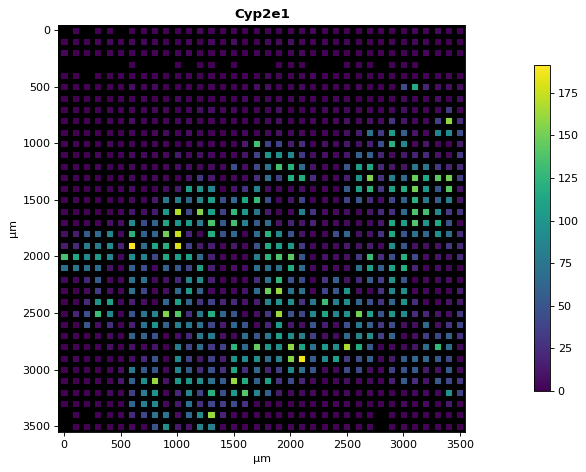

In [22]:
db.pl.spatial(adata, keys="Cyp2e1")

In [20]:
adata.uns['spatial']

{'align': {'images': {'hires': array([[[ 8,  8,  8],
           [ 8,  8,  8],
           [ 8,  8,  8],
           ...,
           [11, 11, 11],
           [11, 11, 11],
           [11, 11, 11]],
   
          [[ 8,  8,  8],
           [ 8,  8,  8],
           [ 9,  9,  9],
           ...,
           [11, 11, 11],
           [11, 11, 11],
           [11, 11, 11]],
   
          [[ 8,  8,  8],
           [ 8,  8,  8],
           [ 9,  9,  9],
           ...,
           [12, 12, 12],
           [12, 12, 12],
           [11, 11, 11]],
   
          ...,
   
          [[ 7,  7,  7],
           [ 7,  7,  7],
           [ 7,  7,  7],
           ...,
           [ 8,  8,  8],
           [ 8,  8,  8],
           [ 8,  8,  8]],
   
          [[ 7,  7,  7],
           [ 7,  7,  7],
           [ 7,  7,  7],
           ...,
           [ 8,  8,  8],
           [ 8,  8,  8],
           [ 8,  8,  8]],
   
          [[ 7,  7,  7],
           [ 7,  7,  7],
           [ 7,  7,  7],
           ...,
       

In [71]:
# input parameters
well_id = 0
alignment_id = 1
image_names = ['bf', 'align', 'phalloidin', 'dapi']

# image path
#image_path = r"N:\01 HPC\03 Team Meier\10_Resources\08_Johannes Wirth\Nextcloud\DbitX\data\37_30\images"
image_path = "/Users/Johannes/Nextcloud/DbitX/data/37_30/images/"

# transcriptome path
matrix_file = r"N:\01 HPC\03 Team Meier\10_Resources\08_Johannes Wirth\Nextcloud\DbitX\data\37_30\transcriptome\wells\A1\DGE_matrix_with_introns_min100.txt.gz"

# output directory
output_name = "37_28_adata_raw_with_images.h5ad"

In [66]:
# get image names
well_names = os.listdir(image_path)
well_name = well_names[well_id]
image_names = os.listdir(os.path.join(image_path,well_name))

In [67]:
# load images
images = [cv2.imread(os.path.join(image_path, well_name, name), -1) for name in image_names]

In [68]:
alignment_image = images[alignment_id]

### Select corner spots in alignment image using napari viewer

In [74]:
viewer = napari.view_image(alignment_image, title="Select corner spots in alignment image of well " + well_name)

#### Extract pivot spot and calibration points from viewer

In [70]:
# fetch vertices (center points of )
corner_spots_center = viewer.layers["Points"].data.astype(int)

In [26]:
# values from 37_28
#corner_spots_center = np.array([[ 486,  990],[ 891, 8662], [8567, 8324],[8164,  646]])

### Create adata with images and metadata

In [73]:
savepath = os.path.join(well_path, output_name)

adata = db.dbitseq_to_squidpy(matrix_path=matrix_file, images=images, labels=image_names, vertices=corner_spots_center, 
                              resolution=50, n_channels=38, frame=100, savepath=savepath)

Read transcriptome matrix...
Align and create image metadata...
     Align images...
     Create metadata...
     Summarized aligned images and metadata...
Compute coordinates...
Adata object generated.
Saving image...
Adata object saved into N:\01 HPC\03 Team Meier\10_Resources\08_Johannes Wirth\Nextcloud\DbitX\data\37_30\images\A1\37_28_adata_raw_with_images.h5ad
Finished


## Write total data to file

In [43]:
adata.write(os.path.join(well_path, output_name))